Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name)).split()
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'a', 'originated', 'originated', 'of', 'as', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

def run_graph():
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print('Initialized')
      average_loss = 0
      for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
          if step > 0:
            average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step %d: %f' % (step, average_loss))
          average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log = '%s %s,' % (log, close_word)
            print(log)
      return normalized_embeddings.eval()
    
%time final_embeddings = run_graph()

Initialized
Average loss at step 0: 8.245386
Nearest to b: murakami, salicylic, backfield, kola, residency, disposing, shorten, fission,
Nearest to up: andriessen, pieces, whale, conan, fausto, know, downhill, dicke,
Nearest to can: brass, braintree, pittsburg, battleship, commenting, miscellany, shackleton, rubbing,
Nearest to about: enact, celery, sarcophagi, analgesics, sonja, featuring, showed, stations,
Nearest to but: haggard, leninist, ionization, btr, giles, stalled, hermaphroditus, websites,
Nearest to also: ctesiphon, insulators, asparagales, pontificia, except, oiled, barnet, encyclopedia,
Nearest to if: rca, galicia, lzw, falsification, pooled, kyanite, hip, timer,
Nearest to not: reminiscent, setups, grosz, cements, tolvaj, fl, ivoire, memos,
Nearest to by: feud, tiers, southern, eldorado, stance, anchor, clarity, laban,
Nearest to used: kh, cord, funicular, water, cupola, yokohama, jerzy, dissipated,
Nearest to from: rature, mandarin, immigrant, bering, trs, crassus, capr

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
%time two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

CPU times: user 2.1 s, sys: 134 ms, total: 2.23 s
Wall time: 1.53 s


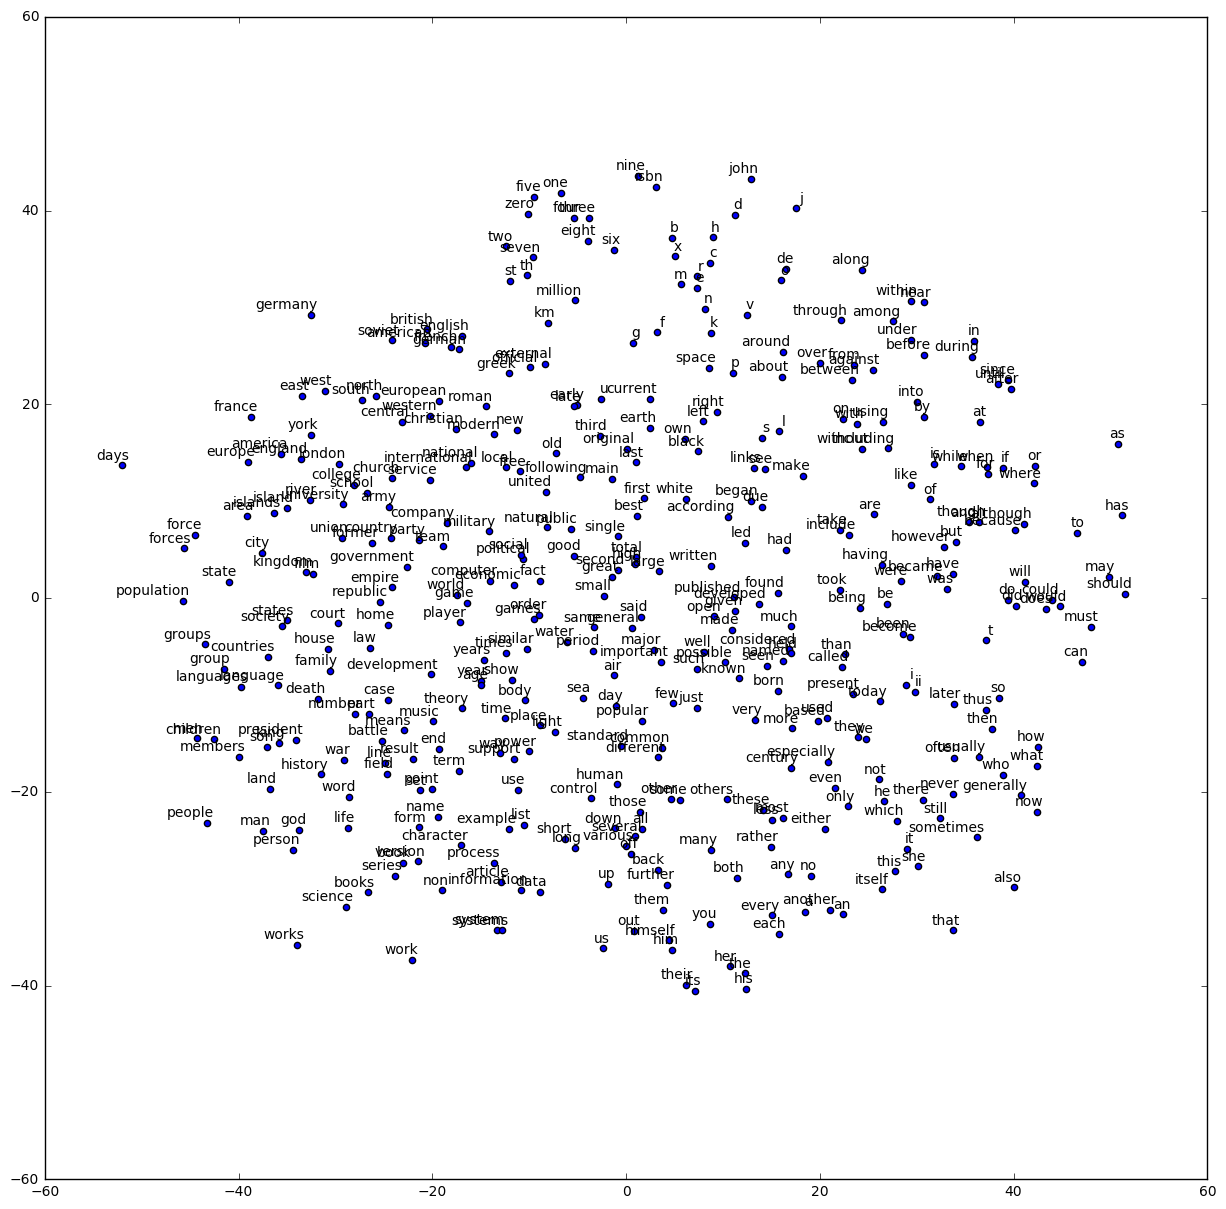

In [9]:
%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [10]:
def generate_random_cbow_batch(batch_size, skip_window):
    context = np.ndarray(shape=(batch_size, 2 * skip_window), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    for i in range(batch_size):
        target = random.randint(skip_window, len(data) - skip_window - 1)
        context[i] = np.array(data[target-skip_window:target] + data[target+1:target+skip_window+1])
        labels[i, 0] = np.array(data[target])
    return context, labels

for skip_window in [1, 2]:
    batch, labels = generate_random_cbow_batch(batch_size=8, skip_window=skip_window)
    print('\nwith skip_window = %d:' % skip_window)
    print('    batch:', [map(lambda y: reverse_dictionary[y], x) for x in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with skip_window = 1:
    batch: [['without', 'approval'], ['health', 'and'], ['to', 'and'], ['nine', 'the'], ['and', 'plays'], ['air', 'thai'], ['nine', 'zero'], ['with', 'are']]
    labels: ['proper', 'declined', 'infinity', 'eight', 'other', 'system', 'nine', 'stroke']

with skip_window = 2:
    batch: [['a', 'typical', 'four', 'one'], ['for', 'expert', 'was', 'introduced'], ['by', 'either', 'two', 'types'], ['for', 'imax', 'and', 'has'], ['the', 'pious', 'the', 'battle'], ['children', 'l', 'jr', 'one'], ['it', 'is', 'loosely', 'applied'], ['military', 'academy', 'point', 'one']]
    labels: ['star', 'players', 'of', 'theaters', 'in', 'ron', 'often', 'west']


In [11]:
batch_size = 100
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * skip_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)), name='weights')
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name='biases')
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset), reduction_indices=1, name='embed')
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size), name='loss')

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001

def run_graph():
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print('Initialized')
      average_loss = 0
      for step in range(num_steps):
        batch_data, batch_labels = generate_random_cbow_batch(
          batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
          if step > 0:
            average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step %d: %f' % (step, average_loss))
          average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log = '%s %s,' % (log, close_word)
            print(log)
      return normalized_embeddings.eval()
    
%time final_embeddings = run_graph()

Initialized
Average loss at step 0: 7.085629
Nearest to also: flop, sigismund, seydlitz, rann, patented, challengers, behavior, prohibitive,
Nearest to states: vince, execute, justices, optative, riviera, imaginable, attending, mechanization,
Nearest to nine: signaling, regimes, kangchenjunga, beget, men, tinker, jazzy, acetic,
Nearest to a: essentially, canaan, inventions, nemo, turnovers, antiquated, ncs, slovenes,
Nearest to their: bouchard, emits, enlist, akihabara, lancashire, stig, reddish, milt,
Nearest to so: xxx, data, hobby, dicotyledons, floppies, tampa, scale, pallas,
Nearest to after: earl, rinse, modesty, courtois, rijeka, budapest, balas, deist,
Nearest to b: larmor, npc, backtracking, quixtar, demyelinating, rescheduled, genus, lionheart,
Nearest to many: carducci, webber, burying, shoe, roque, chalker, sofia, solvable,
Nearest to however: splinter, reductase, hamlets, beverage, kip, twists, gamete, circumvented,
Nearest to six: lithography, asshole, undertake, dedicate

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
%time two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

CPU times: user 2.13 s, sys: 174 ms, total: 2.3 s
Wall time: 1.64 s


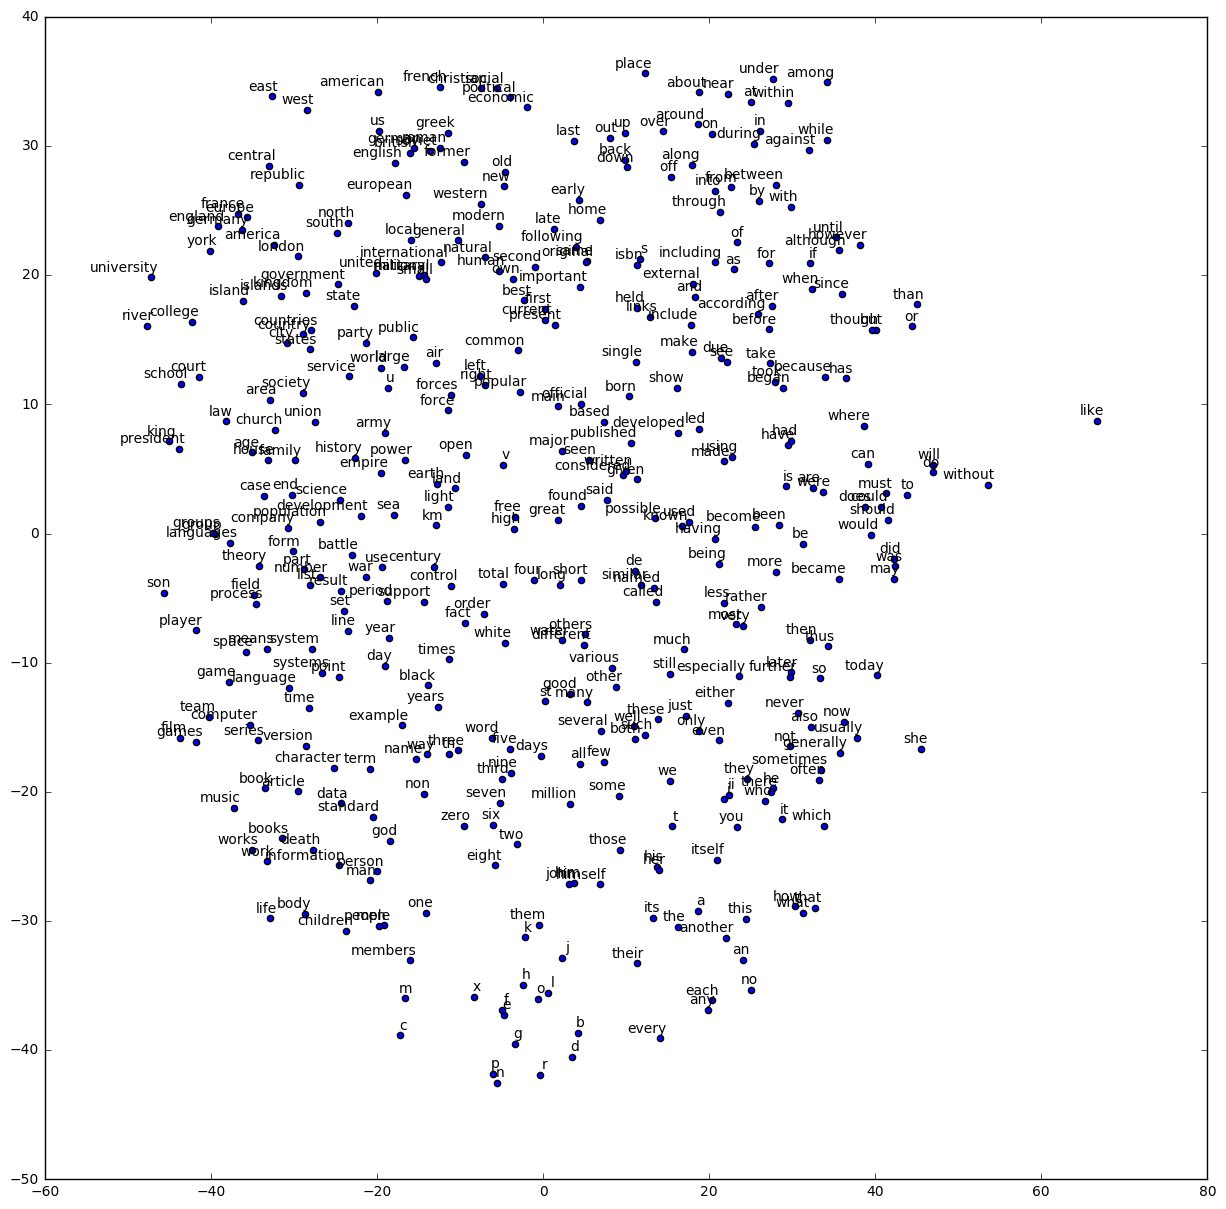

In [14]:
%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)